In [57]:
from pathlib import Path
import pandas
import numpy

# Import all files and merge all data into a single data frame
df = pandas.DataFrame()
for file in Path('../data').glob('*.csv'):
    site = file.stem
    print("Processing {}...".format(site))

    # Load csv file
    _df = pandas.read_csv("../data/{}.csv".format(site), dtype={'YYYYMMDD': str, 'HHMM': str})
    _df['HHMM'] = _df['HHMM'].str.zfill(4)
    _df.insert(0, 'Datetime', pandas.to_datetime(_df['YYYYMMDD'] + _df['HHMM']))
    _df = _df.drop(columns=['YYYYMMDD', 'HHMM'])
    _df = _df.set_index(['Datetime'])

    # TaiMoShan.csv is different from other files:
    if site == 'TaiMoShan':
        # 1) It has 2 Wind Direction columns, i.e.: #3 "Wind Direction (deg) " and #5 "Wind Direction (deg)", handle it before merging
        _df['Wind Direction (deg) '] = _df['Wind Direction (deg) '].fillna(_df['Wind Direction (deg)'])
        _df = _df.drop(columns=['Wind Direction (deg)'])
        # 2) Wind Direction column is in a format of xx.0, convert it to integer before merging for consistency
        _df = _df.astype({'Wind Direction (deg) ': 'int64'})

    # Add site name to column name, remove leading and tailing spaces
    _df.columns = [site + ' ' + column_name_original.strip() for column_name_original in _df.columns]

    # Merge data frame
    df = pandas.concat([df, _df], axis=1)

df.to_excel("output.xlsx")
print(df.info())

Processing ChekLapKok...
Processing CheungChau...
Processing KingsPark...
Processing LauFauShan...
Processing PengChau...
Processing SaiKung...
Processing ShaTin...
Processing ShekKong...
Processing TaiMoShan...
Processing TaKwuLing...
Processing TatesCairn...
Processing TseungKwanO...
Processing Waglan...
Processing WetlandPark...
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 133656 entries, 2008-01-01 00:01:00 to 2023-03-31 23:01:00
Data columns (total 70 columns):
 #   Column                                Non-Null Count   Dtype
---  ------                                --------------   -----
 0   ChekLapKok Temperature (0.1 C)        133656 non-null  int64
 1   ChekLapKok Relative Humidity (%)      133656 non-null  int64
 2   ChekLapKok Wind Speed (0.1 m/s)       133656 non-null  int64
 3   ChekLapKok Wind Direction (deg)       133656 non-null  int64
 4   ChekLapKok 60-min Rainfall (0.1 mm)   133656 non-null  int64
 5   CheungChau Temperature (0.1 C)        133656 non-null 

In [2]:
from pathlib import Path
import pandas
import numpy
df=pandas.read_excel('output.xlsx')
df=df.set_index(['Datetime'])
print(df.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 133656 entries, 2008-01-01 00:01:00 to 2023-03-31 23:01:00
Data columns (total 70 columns):
 #   Column                                Non-Null Count   Dtype
---  ------                                --------------   -----
 0   ChekLapKok Temperature (0.1 C)        133656 non-null  int64
 1   ChekLapKok Relative Humidity (%)      133656 non-null  int64
 2   ChekLapKok Wind Speed (0.1 m/s)       133656 non-null  int64
 3   ChekLapKok Wind Direction (deg)       133656 non-null  int64
 4   ChekLapKok 60-min Rainfall (0.1 mm)   133656 non-null  int64
 5   CheungChau Temperature (0.1 C)        133656 non-null  int64
 6   CheungChau Relative Humidity (%)      133656 non-null  int64
 7   CheungChau Wind Speed (0.1 m/s)       133656 non-null  int64
 8   CheungChau Wind Direction (deg)       133656 non-null  int64
 9   CheungChau 60-min Rainfall (0.1 mm)   133656 non-null  int64
 10  KingsPark Temperature (0.1 C)         133656 non-null  int

In [21]:
df_range.corr()

,Temperature,Wind,Rainfall,Humid
Temperature,1.000000,-0.173060,0.073825,0.235193
Wind,-0.173060,1.000000,0.126080,0.156981
Rainfall,0.073825,0.126080,1.000000,0.088902
Humid,0.235193,0.156981,0.088902,1.000000


In [41]:
from keras.utils.np_utils import to_categorical
import numpy

# As an example, create dataset using WetlandPark Temperature.
# Mark invalid data as numpy.nan
df_range = pandas.DataFrame(df[['TaiMoShan Temperature (0.1 C)','TaiMoShan Wind Speed (0.1 m/s)','TaiMoShan 60-min Rainfall (0.1 mm)','TaiMoShan Relative Humidity (%)']].replace(32767, numpy.nan))
df_range.rename(columns = {'TaiMoShan Temperature (0.1 C)':'Temperature','TaiMoShan Wind Speed (0.1 m/s)':'Wind','TaiMoShan 60-min Rainfall (0.1 mm)':'Rainfall','TaiMoShan Relative Humidity (%)':'Humid'}, inplace = True)

# For each day in range
from datetime import date, timedelta, datetime
start_date = datetime(2013, 1, 1)
end_date = datetime(2023, 1, 1)

# Python generator to provide date range
# Reference: https://stackoverflow.com/questions/1060279/iterating-through-a-range-of-dates-in-python
def daterange(start_date, end_date):
    for n in range(int((end_date - start_date).total_seconds()//3600)):
        yield start_date + timedelta(hours=n)

# Create dataset
dataset_inputs_1 = []
dataset_inputs_2 = []
dataset_inputs_3 = []
dataset_inputs_4 = []
dataset_inputs_5 = []
dataset_inputs_6 = []
dataset_outputs = []
for single_date in daterange(start_date, end_date):
    if df_range[single_date-timedelta(hours=7*24):single_date+timedelta(hours=24)].isnull().values.any():
        continue  # Skip data with nan
    df_previous_week = df_range[single_date-timedelta(hours=7*24):single_date]
    df_coming_day = df_range[single_date:single_date+timedelta(hours=24)]

    temperature_input = numpy.asarray(df_previous_week['Temperature'].values.tolist(), dtype=numpy.float32)
    wind_input = numpy.asarray(df_previous_week['Wind'].values.tolist(), dtype=numpy.float32)
    rain_input = numpy.asarray(df_previous_week['Rainfall'].values.tolist(), dtype=numpy.float32)
    month_input = to_categorical(single_date.month - 1, num_classes=12, dtype=numpy.float32)
    hour_input = to_categorical(single_date.hour, num_classes=24, dtype=numpy.float32)
    humid_input = numpy.asarray(df_previous_week['Humid'].values.tolist(),dtype=numpy.float32)
    temperature_output = numpy.asarray(df_coming_day['Temperature'].values.tolist(), dtype=numpy.float32)

    dataset_inputs_1.append(temperature_input)
    dataset_inputs_2.append(month_input)
    dataset_inputs_3.append(hour_input)
    dataset_inputs_4.append(wind_input)
    dataset_inputs_5.append(rain_input)
    dataset_inputs_6.append(humid_input)
    dataset_outputs.append(temperature_output)
    
dataset = list(zip(dataset_inputs_1, dataset_inputs_2, dataset_inputs_3, dataset_inputs_4, dataset_inputs_5,dataset_inputs_6, dataset_outputs))

In [42]:
# Seperate Dataset into 3 parts: training set, validation set, test set
# For validation set, we use tensorflow's model fit built-in feature to achieve it

DATASET_SIZE = len(dataset)
trainval_size = int(0.9 * DATASET_SIZE)
test_size = int(DATASET_SIZE - trainval_size)
print('Dataset Size:', DATASET_SIZE)
print('Training Set + Validation Set Size:', trainval_size)
print('Test Set:', test_size)

import random
random.shuffle(dataset)

dataset_trainval = dataset[:trainval_size]
dataset_test = dataset[trainval_size:]

trainval_input_1, trainval_input_2, trainval_input_3, trainval_input_4, trainval_input_5, trainval_input_6, trainval_output = list(zip(*dataset_trainval))
test_input_1, test_input_2, test_input_3, test_input_4, test_input_5, test_input_6, test_output = list(zip(*dataset_test))

trainval_input_1 = numpy.asarray(trainval_input_1)
trainval_input_2 = numpy.asarray(trainval_input_2)
trainval_input_3 = numpy.asarray(trainval_input_3)
trainval_input_4 = numpy.asarray(trainval_input_4)
trainval_input_5 = numpy.asarray(trainval_input_5)
trainval_input_6 = numpy.asarray(trainval_input_6)
trainval_output = numpy.asarray(trainval_output)
test_input_1 = numpy.asarray(test_input_1)
test_input_2 = numpy.asarray(test_input_2)
test_input_3 = numpy.asarray(test_input_3)
test_input_4 = numpy.asarray(test_input_4)
test_input_5 = numpy.asarray(test_input_5)
test_input_6 = numpy.asarray(test_input_6)
test_output = numpy.asarray(test_output)

Dataset Size: 52129
Training Set + Validation Set Size: 46916
Test Set: 5213


In [61]:
temperature_input.shape[0]

168

In [43]:
# Define the architecture of the model

import tensorflow as tf
print(tf.__version__)

temperature_input = tf.keras.Input(shape=(temperature_input.shape[0],))
month_input = tf.keras.Input(shape=(month_input.shape[0],))
hour_input = tf.keras.Input(shape=(hour_input.shape[0],))
wind_input = tf.keras.Input(shape=(wind_input.shape[0],))
rain_input = tf.keras.Input(shape=(rain_input.shape[0],))
humid_input = tf.keras.Input(shape=(humid_input.shape[0],))

merged_model = tf.keras.layers.concatenate([temperature_input, month_input, hour_input,wind_input,rain_input,humid_input])
dense1 = tf.keras.layers.Dense(256, activation=tf.keras.layers.LeakyReLU(alpha=0.01))(merged_model)
dense2 = tf.keras.layers.Dense(128, activation=tf.keras.layers.LeakyReLU(alpha=0.01))(dense1)
dense3 = tf.keras.layers.Dense(64, activation=tf.keras.layers.LeakyReLU(alpha=0.01))(dense2)
dense4 = tf.keras.layers.Dense(24, activation=tf.keras.layers.LeakyReLU(alpha=0.01))(dense3)

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=20)
model = tf.keras.models.Model(inputs=[temperature_input, month_input, hour_input,wind_input,rain_input,humid_input], outputs=dense4)
model.summary()

model.compile(loss=tf.keras.losses.MeanSquaredError(),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=[tf.keras.metrics.MeanAbsoluteError()])

2.14.0-dev20230518
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_19 (InputLayer)       [(None, 168)]                0         []                            
                                                                                                  
 input_20 (InputLayer)       [(None, 12)]                 0         []                            
                                                                                                  
 input_21 (InputLayer)       [(None, 24)]                 0         []                            
                                                                                                  
 input_22 (InputLayer)       [(None, 168)]                0         []                            
                                                                         

In [44]:
# Model Training

MODEL_FOLDER = '../model'

from datetime import datetime
from pathlib import Path

history=model.fit(
    x=[trainval_input_1, trainval_input_2, trainval_input_3,trainval_input_4,trainval_input_5,trainval_input_6],
    y=trainval_output,
    validation_split=0.15,
    epochs=300,
    callbacks=[callback]
)

test_loss, test_mean_absolute_error = model.evaluate(x=[test_input_1, test_input_2, test_input_3,test_input_4,test_input_5,test_input_6], y=test_output)
print('\nTest Mean Absolute Error:', test_mean_absolute_error)

model_file_name = 'model-{}'.format(datetime.now().strftime('%Y%m%d-%H%M%S'))
model_file = Path(MODEL_FOLDER) / model_file_name
model.save(model_file)
print('Model {} saved'.format(model_file_name))


Epoch 1/300


1247/1247 [==============================] - 6s 4ms/step - loss: 760.7733 - mean_absolute_error: 17.0694 - val_loss: 426.4673 - val_mean_absolute_error: 16.4170
Epoch 2/300
1247/1247 [==============================] - 5s 4ms/step - loss: 327.9634 - mean_absolute_error: 13.3948 - val_loss: 285.0106 - val_mean_absolute_error: 12.2844
Epoch 3/300
1247/1247 [==============================] - 4s 4ms/step - loss: 300.5214 - mean_absolute_error: 12.7409 - val_loss: 282.5563 - val_mean_absolute_error: 12.3150
Epoch 4/300
1247/1247 [==============================] - 6s 4ms/step - loss: 290.3274 - mean_absolute_error: 12.5101 - val_loss: 305.1718 - val_mean_absolute_error: 13.1848
Epoch 5/300
1247/1247 [==============================] - 5s 4ms/step - loss: 283.3291 - mean_absolute_error: 12.3278 - val_loss: 325.2005 - val_mean_absolute_error: 13.2509
Epoch 6/300
1247/1247 [==============================] - 6s 5ms/step - loss: 272.9836 - mean_absolute_error: 12.0693 - val_loss: 276.5322 - val_mea

INFO:tensorflow:Assets written to: ..\model\model-20230626-112220\assets


Model model-20230626-112220 saved


In [47]:
import plotly as px
import pandas as pd
px.plot(pd.DataFrame(history.history)[['loss','val_loss']],kind='line')


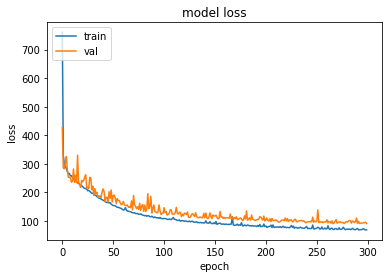

In [48]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [58]:
# Plot a random prediction result from test set

import random
example_index = test_size-1

example_input_1 = test_input_1[example_index]
example_input_2 = test_input_2[example_index]
example_input_3 = test_input_3[example_index]
example_input_4 = test_input_4[example_index]
example_input_5 = test_input_5[example_index]
example_input_6 = test_input_6[example_index]
example_truth = test_output[example_index]

example_output = model.predict(x=[numpy.array([example_input_1])
                                  , numpy.array([example_input_2])
                                  , numpy.array([example_input_3])
                                  , numpy.array([example_input_4])
                                  , numpy.array([example_input_5])
                                  , numpy.array([example_input_6])])[0]

import plotly.express as px
fig = px.line({'Prediction': [*example_input_1, *example_output], 'Truth': [*example_input_1, *example_truth]})
fig.update_layout(yaxis_range=[0, 400])
fig.update_yaxes(fixedrange=True)
fig.show()
from sklearn.metrics import mean_squared_error
import pandas as pd
print('rmse: '+str(mean_squared_error([*example_output],[*example_truth])**0.5/10))

1/1 [==============================] - 1s 1s/step


rmse: 0.8729452803723806


<function matplotlib.pyplot.xticks(ticks=None, labels=None, *, minor=False, **kwargs)>

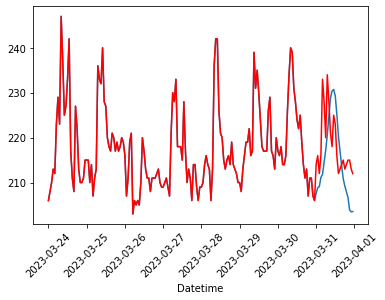

In [50]:
import seaborn as sns
import matplotlib.pyplot as plt
fig,ax=plt.subplots(1)
pred=list(example_input_1)+list(example_output)
actual=list(example_input_1)+list(example_truth)
sns.lineplot(x=df_range.index[-len(pred):],y=pred,ax=ax)
sns.lineplot(x=df_range.index[-len(pred):],y=actual,ax=ax,c='r')
plt.xticks(rotation=45)
plt.xticks

In [51]:
from sklearn.metrics import mean_squared_error
import pandas as pd
print('rmse: '+str(mean_squared_error([*example_output],[*example_truth])**0.5/10))
summary=pd.DataFrame({'Prediction': [*example_input_1, *example_output], 'Truth': [*example_input_1, *example_truth]})
summary=summary/10
summary=summary[-len(example_truth):]
summary['Diff']=summary['Prediction']-summary['Truth']
summary
px.line(summary[['Prediction','Truth']],markers='s')

rmse: 0.8729452803723806


In [52]:
start_date = datetime(2023, 3, 29,0,0,0)
end_date = datetime(2023, 3, 30,0,0,0)
# Create dataset
dataset_inputs_1 = []
dataset_inputs_2 = []
dataset_inputs_3 = []
dataset_inputs_4 = []
dataset_inputs_5 = []
dataset_inputs_6 = []
dataset_outputs = []
for single_date in daterange(start_date, end_date):
    if df_range[single_date-timedelta(hours=7*24):single_date+timedelta(hours=24)].isnull().values.any():
        continue  # Skip data with nan
    df_previous_week = df_range[single_date-timedelta(hours=7*24):single_date]
    df_coming_day = df_range[single_date:single_date+timedelta(hours=24)]

    temperature_input = numpy.asarray(df_previous_week['Temperature'].values.tolist(), dtype=numpy.float32)
    wind_input = numpy.asarray(df_previous_week['Wind'].values.tolist(), dtype=numpy.float32)
    rain_input = numpy.asarray(df_previous_week['Rainfall'].values.tolist(), dtype=numpy.float32)
    month_input = to_categorical(single_date.month - 1, num_classes=12, dtype=numpy.float32)
    humid_input = numpy.asarray(df_previous_week['Humid'].values.tolist(), dtype=numpy.float32)
    hour_input = to_categorical(single_date.hour, num_classes=24, dtype=numpy.float32)
    temperature_output = numpy.asarray(df_coming_day['Temperature'].values.tolist(), dtype=numpy.float32)


    dataset_inputs_1.append(temperature_input)
    dataset_inputs_2.append(month_input)
    dataset_inputs_3.append(hour_input)
    dataset_inputs_4.append(wind_input)
    dataset_inputs_5.append(rain_input)
    dataset_inputs_6.append(humid_input)
    dataset_outputs.append(temperature_output)
    
dataset = list(zip(dataset_inputs_1, dataset_inputs_2, dataset_inputs_3, dataset_inputs_4, dataset_inputs_5,dataset_inputs_6, dataset_outputs))
example_input_1=dataset[0][0]
example_input_2=dataset[0][1]
example_input_3=dataset[0][2]
example_input_4=dataset[0][3]
example_input_5=dataset[0][4]
example_input_6=dataset[0][5]

In [53]:
import tensorflow as tf
#model=tf.keras.models.load_model('C:/Users/squar/Desktop/HKO/Experiments/model/model-20230522-210104')
example_output = model.predict(x=[numpy.array([example_input_1])
                                  , numpy.array([example_input_2])
                                  , numpy.array([example_input_3])
                                  , numpy.array([example_input_4])
                                  , numpy.array([example_input_5])
                                  , numpy.array([example_input_6])])[0]

1/1 [==============================] - 0s 44ms/step


<function matplotlib.pyplot.xticks(ticks=None, labels=None, *, minor=False, **kwargs)>

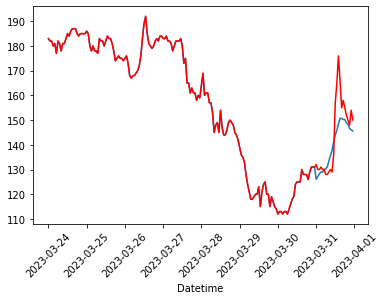

In [54]:
import seaborn as sns
import matplotlib.pyplot as plt
fig,ax=plt.subplots(1)
pred=list(example_input_1)+list(example_output)
actual=list(example_input_1)+list(dataset_outputs[0])
sns.lineplot(x=df_range.index[-len(pred):],y=pred,ax=ax)
sns.lineplot(x=df_range.index[-len(pred):],y=actual,ax=ax,c='r')
plt.xticks(rotation=45)
plt.xticks

In [55]:
sum=pd.DataFrame({'pred':example_output,'actual':dataset_outputs[0]})
sum['pred']=round(sum['pred'])
sum['diff']=sum['actual']-sum['pred']
sum['diff'].apply(abs).mean()/10

0.6375

In [56]:
import plotly as px
start_date = datetime(2023, 3, 29,0,1,0)
end_date = datetime(2023, 3, 31,0,1,0)
d=df_range.loc[start_date:][['Temperature']][:24]
d['pred']=example_output
d['pred']=round(d['pred'])
px.plot(d,kind='line',markers='s')